# Assignment 2: SoC Module Recommender System

## Instructions to submit the assignment

- Name your jupyter notebook as `Assignment2_[StudentID].ipynb`. For instance: `Assignment2_A0123873A.ipynb`
- Your solution notebook must contain the python code that we can run to verify the answers.
- Upload your jupyter notebook on LumiNUS in the *Assignment 1 Submissions* folder. The folder will close at 4pm on 02/04/2021. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark
- **This is an individual assessment. Refrain from working in groups.**

In this assignment we design a reccomendation engine. The recommendation engine suggests the students a module that closely matches the modules already taken by the student. The dataset comprices of two files:
- List of modules in the School of Computing 
- List of graduated students and the modules they had taken during their studies

# Loading the data

In [731]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
!pip3.9 install nltk

'''
    YOU MUST USE THE RANDOM SEED WHEREVER NEEDED
'''
rng = np.random.default_rng(seed=42)

courses = pd.read_csv("courses.tsv", sep='\t')
students = pd.read_csv("students.tsv", sep='\t')

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


# Question 1: Creating the preprocessing pipeline

We want to create a sklearn pipeline to efficiently preprocess the data and prepare it for training a model. We use three different features in the `courses` data: `specialisation`, `info` and `workload`. We want to represent every feature in a numeric form and merge them to form a feature vector for every course. We do so in the following way:
- `specialisation` represents one of the six levels of the module. For instance: CS2103 is a Software Engineering (SE) specialisation module. Encode this categorical feature into a vector. The decision of handling missing values is left to you! *(Hint: You can use `MultiLabelBinerizer` to do so.)*
- `info` provides a short discription of the module. We want to convert it into a vector using CountVectorizer. *Don't forget to remove the stopwords* while doing so.
-  `workload` states the intended distribution of workload over lectures, tutorials, labs and self study. We want to find the workload as the sum of individual workloads. For instnce: 3-1-1-3-2 workload transforms to 10 hours.

Provide implementation for three classes that help us build the pipeline. `transformed_courses` should be a numpy array of shape `[n_courses X n_features]`.

                                                                                                   (6 marks)

In [1186]:
students.head()
courses.head()

,code,name,credits,workload,info,specialisation
0,CS1010,Programming Methodology,4,2-1-1-3-3,"This module introduces the fundamental concepts of problem solving by computing and programming using an imperative programming language. It is the first and foremost introductory course to computing. It is also the first part of a three-part series on introductory programming and problem solving by computing, which also includes CS1020 and CS2010. Topics covered include problem solving by computing, writing pseudo-codes, basic problem formulation and problem solving, program development, coding, testing and debugging, fundamental programming constructs (variables, types, expressions, assignments, functions, control structures, etc.), fundamental data structures: arrays, strings and structures, simple file processing, and basic recursion. This module is appropriate for SoC students.",Core
1,CS1010FC/X,Programming Methodology,4,2-1-1-3-3,"This module introduces the fundamental concepts of problem solving by computing and programming using an imperative programming language. It is the first and foremost introductory course to computing and is equivalent to CS1010, CS1010S and CS1010E Programming Methodology. The module will be taught using the Python programming language and topics covered include problem solving by computing, writing pseudo-codes, basic problem formulation and problem solving, program development, coding, testing and debugging, fundamental programming constructs (variables, types, expressions, assignments, functions, control structures, etc.), fundamental data structures: arrays, strings and structures, simple file processing, and basic recursion.",Core
2,CS1010E,Programming Methodology,4,2-1-1-3-3,"This module introduces the fundamental concepts of problem solving by computing and programming using an imperative programming language. It is the first and foremost introductory course to computing. It is also the first part of a three-part series on introductory programming and problem solving by computing, which also includes CS1020E and CS2010. Topics covered include problem solving by computing, writing pseudo-codes, basic problem formulation and problem solving, program development, coding, testing and debugging, fundamental programming constructs (variables, types, expressions, assignments, functions, control structures, etc.), fundamental data structures: arrays, strings and structures, simple file processing, and basic recursion.This module is appropriate for FoE students.",Core
3,CS1010J,Programming Methodology,4,2-1-1-3-3,"This module introduces the fundamental concepts of problem solving by computing and programming using an imperative programming language. It is the first and foremost introductory course to computing. It is also the first part of a three-part series on introductory programming and problem solving by computing, which also includes CS1020E and CS2010. Topics covered include problem solving by computing, writing pseudo-codes, basic problem formulation and problem solving, program development, coding, testing and debugging, fundamental programming constructs (variables, types, expressions, assignments, functions, control structures, etc.), fundamental data structures: arrays, strings and structures, simple file processing, and basic recursion. This module is appropriate for B.Comp.(IS) and B.Comp.(EC) students.",Core
4,CS1010S,Programming Methodology,4,2-1-1-3-3,"This module introduces the fundamental concepts of problem solving by computing and programming using an imperative programming language. It is the first and foremost introductory course to computing and is equivalent to CS1010 and CS1010E Programming Methodology. Topics covered include problem solving by computing, writing pseudo-codes, basic problem formulation and problem solving, program development, coding, testing and debugging, fundamental programming constructs (variables, types, expressions, assignments, functions, control struct

In [1187]:
class WorkloadTransformer:        
    def fit(self, X, y = None, **fit_params):
        print('fitted')
        return self
        
    def transform(self, X, y = None, **fit_params):
        X_ = X.copy()
        X_.dropna(inplace=True)
        X_["workload"] = X_["workload"].apply(lambda field: sum([float(x) for x in field.split("-")]))
    
        return pd.DataFrame(X_["workload"])

In [1190]:
import nltk
import string
import re
from nltk.corpus import stopwords

class InfoTransformer:        
    def textTransform(self, text, testing=False):
        try:
            text = text.lower() # convert text to lower case
            if testing==True:
                print(text)
            regex = re.compile('['+re.escape(string.punctuation) + '0-9\\r\\t\\n'+']')
            txt = regex.sub('',text)  # remove punctuation
            if testing==True:
                print(txt)
            words = [w for w in txt.split(' ')
                    if w not in stop] # remove stop words and words with length smaller than 3 letters. create array of remaining words
            if testing==True:
                print(words)
            return words
        except:
            return 0
        
    def fit(self, X, y = None, **fit_params):
        X_= X.copy()    
        X_.dropna(inplace=True) 
        stop = stopwords.words('english')
        X_["transformed_info_string"] = X_["info"].apply(self.textTransform).apply(lambda field: ' '.join([str(item) for item in list(field)]))

        count_vect = CountVectorizer()
        count_vect.fit(X_.transformed_info_string)
        print("fitted")
        return self
    
    def transform(self, X, y = None, **fit_params):
        X_= X.copy()
        X_.dropna(inplace=True)
        stop = stopwords.words('english')
        X_["transformed_info_string"] = X_["info"].apply(self.textTransform).apply(lambda field: ' '.join([str(item) for item in list(field)]))
        X_df = count_vect.transform(X_.transformed_info_string)
        X_df = pd.DataFrame(X_df.toarray())
        return X_df

In [1191]:
import sys
import numpy
from sklearn.preprocessing import MultiLabelBinarizer

class SpecTransformer:        
    def fit(self, X, y = None, **fit_params):
        mlb = MultiLabelBinarizer()
        X_ = X.copy()
        X_.dropna(inplace=True)
        X_["specialisation"].replace("Netoworking", "Networking",inplace=True)
        X_["new"] = X_["specialisation"].apply(lambda field: field.split(','))
        mlb.fit(list(X_['new']))
        print("fitted")
        return self
    
    def transform(self, X, y = None, **fit_params):
        X_ = X.copy()
        X_.dropna(inplace=True)
        X_["specialisation"].replace("Netoworking", "Networking",inplace=True)
        X_["new"] = X_["specialisation"].apply(lambda field: field.split(','))
        X_df = pd.DataFrame(mlb.transform(list(X_['new'])))
        return X_df

In [1192]:
featureTransformer  = FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),
    ('spec_processing', Pipeline([('spec', SpecTransformer())])),
])
featureTransformer.fit(courses)
transformed_courses = featureTransformer.transform(courses)
transformed_courses.shape

fitted
fitted
fitted


(154, 2281)

Now we prepare our testing data in the same way we preprocessed the course. `students` data comprises of 1000 students and a list of modules they have taken. 

Create `Xtest` and `Ytest` as two matrices. `Xtest`, of size `1000*5`, comprises of first five modules for every student in the list. `Ytest`, of size `1000*[remaining_modules]`, comprises of rest of the modules for every student in the list. 
We do so in order to assess the performance of the recommender. We assess the recommender based on its effectiveness to predict the modules given a list of five modules as the input.

For instance: 
- `Xtest[0] = ['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`
- `Ytest[0] = ['CS3282', 'CS6204', 'CS5223', 'CS3281', 'CS4344', 'CS5422', 'CS3237', 'CS5233']`.

<div align="right">(1 mark)</align>

In [1236]:
# Write your code here
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
# Xtest = np.array([x for x in students["courses"].apply(lambda field: sorted(field.split(","))[0:5])])  #sort first
Xtest = np.array([x for x in students["courses"].apply(lambda field: (field.split(","))[0:5])])
# Ytest = [y for y in students["courses"].apply(lambda field: sorted(field.split(","))[5:])] #sort first
Ytest = np.array([y for y in students["courses"].apply(lambda field: (field.split(","))[5:])])

print(Xtest[0:5])
print(Ytest[0:5])

[['CS5422' 'CS5223' 'CS4237' 'CS3281' 'CS6213']
 ['CS6206' 'CS3241' 'CS5237' 'CS4350' 'CS3242']
 ['CS5244' 'CS6270' 'CS6234' 'CS5223' 'CS3230']
 ['CS5422' 'CS3220' 'CS3103' 'CS4224' 'CS4237']
 ['CS6206' 'CS3241' 'CS5240' 'CS4350' 'CS5343']]
[list(['CS6211', 'CS3282', 'CS2100', 'CS2105', 'CS5250', 'CS3210'])
 list(['CS3281', 'CS4235', 'CS6207', 'CS3218', 'CS5343', 'CS6241', 'CS6212', 'CS5240', 'CS6243', 'CS3225', 'CS3249', 'CS4240', 'CS5246', 'CS4242'])
 list(['CS3284', 'CS2281', 'CS6213', 'CS2100', 'CS4345', 'CS5250', 'CS3210', 'CS4212'])
 list(['CS5248', 'CS3281', 'CS3282', 'CS4222', 'CS4231', 'CS6220', 'BT5110', 'CS5321', 'CS6204'])
 list(['CS6243', 'CS6241', 'CS5239', 'CS3281', 'CS3249', 'CS3282', 'CS4351', 'CS6213', 'CS3242', 'CS4345', 'CS2106', 'CS5246', 'CS5224'])]


For every student in `Xtest`, we need to transform the list of 5 modules to the feature space using the `featureTransformer` fit on the training data. For every module we will get a feature vector of size `n_features`. We add these feature vectors to get an aggregate feature vector for very student.

Write a function `getFeatureVector` that takes in the list of modules and `featureTransformer`. It returns the feature vector for the specified list of courses. For instance, `getFeatureVector(Xtest[0], featureTransformer)` will return a vector of size `n_features`.

<div align="right">(3 marks)</div>

In [1195]:
def getFeatureVector(modules, featureTransformer):
    global courses
    student_courses = courses[courses["code"].isin(modules)]
    transformed_courses = featureTransformer.transform(student_courses)
    transformed_courses = sum(transformed_courses).reshape(1,-1)   
    return transformed_courses
getFeatureVector(Xtest[0],featureTransformer).shape

(1, 2281)

# Question 2: Content based recommender

We can use a model as simple as K-nearest neighbour (KNN) to perform a content based recommendation. If we provide a list of 5 modules to the recommender, it provide us a list of modules that are similar to the specified modules.

`sklearn` provides `NearestNeighbors` as well as `KNeighborsClassifier`, both of which have a similar functionality. `NearestNeighbors` provides as an easy functionality to predict a list of K nearest neighbours. Therefore, we prefer it over `KNeighborsClassifier`. If we want to find K nearest points to a datapoint`d`, we need to use `n_neighbors` as K + 1 because the list includes `d` itself.

You can now train the model using the training data, which comprises of `transformed_courses` and with their codes as the labels. 
<div align="right">(1 mark)</div>

In [1197]:
K = 5
model = NearestNeighbors(algorithm = "brute", n_neighbors = K+1)
## Write your code here
model.fit(transformed_courses)
# print(model.kneighbors(featureTransformer.transform(student_courses)))

NearestNeighbors(algorithm='brute', n_neighbors=6)

It is time to see our model in action. Let's see what modules our model reommends based on the modules taken by a student.

Write a function that takes in a *pre-trained* model of your choice as input and the list of modules. It returns the top-K recommendations of the model. Print the top 6 recommendations for the first student. 
<div align="right">(3 marks)</div>

In [1207]:
def recommend(model, modulesTaken, k, featureTransformer_type):
    global courses
    featureTransformer_type
    courses_vector = getFeatureVector(modulesTaken, featureTransformer_type)
    neighbors = model.kneighbors(courses_vector,n_neighbors=k+1)    
    res = [courses[courses.index==x]["code"].values[0] for x in neighbors[1][0][1:]]  
    return res

print("Top 6 Recommendations for Student #1:", *recommend(model, Xtest[0], 6, featureTransformer), sep = "\n - ")

Top 6 Recommendations for Student #1:
 - CS5344
 - CS5250
 - CS4212
 - CS3202
 - CS5232
 - CS3201


# Question 3: Recommender evaluation

Is this the model any good?. To do so, we use **precision** and **recall** as our metrics. `Ytest` consists of true labels for every students. Using those labels as the ground truth, compute the precision and recall for every student. Write a code that prints values of average precision and recall for a specific value of `K` over the `students` dataset. Print the value of average precision and average recall for `K= 10`.

                                                                                                     (2 marks)

In [1230]:
#Manually calculate Precision and Recall, and setting K constant at 10.

# Write your code here
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

model.fit(transformed_courses)

def eval_recommender(model, Xtest, Ytest, k, featureTransformer_type):
    prec_list = []
    rec_list = []
    for i,student in enumerate(Xtest):
        length = k 
        true = Ytest[i]
        predicted = recommend(model,student,length, featureTransformer_type)
        #Manually calculate Precision + Recall
        TP = 0
        for true_course in Ytest[i]:
            if true_course in predicted:
    #             print("Yes")
                TP+=1
        FP = length - TP
        FN = len(Ytest[i]) - TP    
        prec = TP / (TP + FP) 
        rec =  TP / (TP + FN)
        prec_list.append(prec)
        rec_list.append(rec)
    return(np.mean(prec_list), np.mean(rec_list))

avg_prec, avg_rec = eval_recommender(model,Xtest,Ytest,10, featureTransformer)
print("Average Precision for K=10: ", avg_prec)
print("Average Recall for K=10: ", avg_rec)

Average Precision for K=10:  0.07809999999999999
Average Recall for K=10:  0.07820887030066596


We observe that both precision and recall is not really great. The reason might be high feature dimension, which may even be noisy. Append the exisiting `featureTransformer` with a PCA to reduce the dimension. 

Print the value of average precision and recall for `K= 10` after the introduction of PCA.

                                                                                                     (2 marks)

Text(0, 0.5, 'cumulative explained variance')

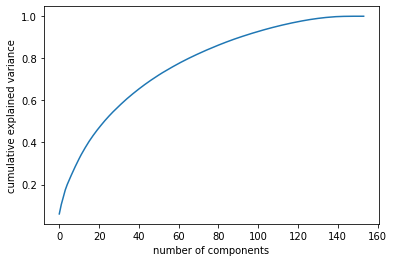

In [1211]:
#Plot out number of components x cumulative explained variance to decide on # of components.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(transformed_courses)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We see that around 100 components can explain roughly 90% of the variance.

In [1224]:
pca = PCA(n_components=100, svd_solver='randomized', whiten=True).fit(transformed_courses)

In [1225]:
from sklearn.pipeline import make_pipeline

featureTransformer_pca = make_pipeline(
    FeatureUnion([
    ('workload_processing', Pipeline([('wrkld', WorkloadTransformer())])),
    ('info_processing', Pipeline([('info', InfoTransformer())])),
    ('spec_processing', Pipeline([('spec', SpecTransformer())])),]
    ), pca)

featureTransformer_pca.fit(courses)
transformed_courses_pca = featureTransformer_pca.transform(courses)

model.fit(transformed_courses_pca)
avg_prec, avg_rec = eval_recommender(model,Xtest,Ytest,10, featureTransformer_pca)
print("Average Precision for K=10 after PCA: ", avg_prec)
print("Average Recall for K=10 after PCA: ", avg_rec)

fitted
fitted
fitted
Average Precision for K=10 after PCA:  0.058800000000000005
Average Recall for K=10 after PCA:  0.05677589367976364


I'm not sure why the precision and recall dropped after doing PCA, but I also noticed the results differed quite a bit when I choose to sort or not sort the student's course vector before splitting into Xtest and Ytest arrays. 

For example, this is an unsorted vector: `['CS2105', 'CS4222', 'CS6270', 'CS6205', 'CS4226']`

While this is a sorted one:
`['CS2105', 'CS4222', 'CS4226', 'CS6205', 'CS6270']`

**With sorting**, the numbers were:\
Without PCA:
- Average Precision: 0.0158
- Average Recall: 0.01468429019381032

After PCA:
- Average Precision: 0.032600000000000004
- Average Recall: 0.03330641347386703

**Without sorting** the courses:\
Without PCA:
- Average Precision: 0.07809999999999999
- Average Recall: 0.07820887030066596

After PCA:
- Average Precision: 0.058800000000000005
- Average Recall: 0.05677589367976364

I chose the unsorted version since it gave higher *overall* Precision and Recall scores.

Extend the code to perform a grid search for the value of `K` that provides the best `F1_score`. Try for values of K from 1 to 10.

                                                                                                     (2 marks)

In [1226]:
# Formula for F1 Score = 2 * (precision * recall) / (precision + recall)

model.fit(transformed_courses_pca)
F1_log = []
for k in range(1,11):
    prec, rec = eval_recommender(model,Xtest,Ytest,k, featureTransformer_pca)
    F1_score = (prec * rec / (prec+rec)) * 2
    print("F1 Score for k=" + str(k) + ": " + str(F1_score))
    F1_log.append(F1_score)
# F1_log

F1 Score for k=1: 0.009679461068362961
F1 Score for k=2: 0.01789853457868103
F1 Score for k=3: 0.0274102096164393
F1 Score for k=4: 0.0349879880890278
F1 Score for k=5: 0.04122371557964853
F1 Score for k=6: 0.045642761063180395
F1 Score for k=7: 0.05032920275515947
F1 Score for k=8: 0.053728799118876784
F1 Score for k=9: 0.056115059021044196
F1 Score for k=10: 0.057770222527894356


[0.009679461068362961,
 0.01789853457868103,
 0.0274102096164393,
 0.0349879880890278,
 0.04122371557964853,
 0.045642761063180395,
 0.05032920275515947,
 0.053728799118876784,
 0.056115059021044196,
 0.057770222527894356]

Text(0.5, 1.0, 'F1_Score vs K')

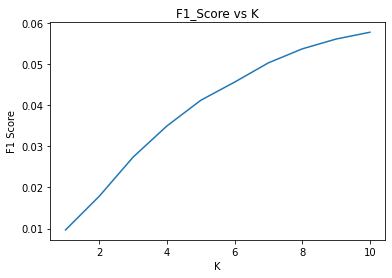

In [1229]:
import matplotlib.pyplot as plt
plt.plot(range(1,11),F1_log)
plt.xlabel("K")
plt.ylabel("F1 Score")
plt.title("F1_Score vs K")

Therefore K=10 still produces the best F1 Score.

# Bonus question

Can you provide some **concrete** (something that you can implement) suggestions to improve the performance of the system?

                                                                                                    (2 marks)

1.
Since we know that the 1st digit in the course code corresponds to the "year" level of the student, we can make use of this information by spreading out the predicted courses over the distribution of years.

For example, if the model receives five 1000-level courses, currently it will likely predict another 1000-level course, based on the similarity of features we are feeding in. However, in reality, there is actually a lesser chance the next courses this student will take will also be 1000-level, so the predictions should really be spread out into a distrubtion over "year" levels. 

A way to implement is when we're creating our Xtest and Ytest, we could sort the course vector first before we split, so that all the courses in Xtest will consist of lower-level courses, while the Ytest will consist of higher-level courses. This makes the training data more consistent, and comparing samples will give more relevant results, whereas currently, the training data will be highly dependent on the order the courses are currently inputted, which looks to be by random.

2.
Since we have Student's dataset, we could directly train the KNN model using Student's dataset instead of the Course's dataset. However, this may not be a fair comparison since it is a completely different model.